# Predicting Financial Inclusion in East Africa
## Data Mining Mid-Term Project — MSDA 9213
### Adventist University of Central Africa (AUCA)
---
**Dataset:** Financial Inclusion in Africa (FinScope Surveys)

**Countries:** Kenya, Rwanda, Tanzania, Uganda

**Task:** Classification (Bank Account Prediction) + Clustering

**Algorithms:** Logistic Regression, Random Forest, Gradient Boosting, MLP Neural Network (Deep Learning)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("figures", exist_ok=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             silhouette_score, roc_curve)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 150
sns.set_style('whitegrid')
print('Libraries loaded successfully!')

Libraries loaded successfully!


## 2. Load and Explore the Dataset

In [2]:
# Load dataset
df = pd.read_csv('Train.csv')
print(f'Dataset shape: {df.shape}')
print(f'\nFirst 5 rows:')
df.head()

Dataset shape: (23524, 13)

First 5 rows:


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [3]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [4]:
# Descriptive statistics
df.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [5]:
# Check missing values
print('Missing values:')
print(df.isnull().sum())
print(f'\nDuplicate rows: {df.duplicated().sum()}')

Missing values:
country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

Duplicate rows: 0


In [6]:
# Target distribution
print('Target Distribution:')
print(df['bank_account'].value_counts())
print(f'\nPercentage:')
print(df['bank_account'].value_counts(normalize=True) * 100)

Target Distribution:
bank_account
No     20212
Yes     3312
Name: count, dtype: int64

Percentage:
bank_account
No     85.920762
Yes    14.079238
Name: proportion, dtype: float64


## 3. Data Cleaning

In [7]:
# Drop uniqueid (identifier, not a feature)
df_clean = df.drop(columns=['uniqueid'])

# Encode target variable
df_clean['bank_account'] = df_clean['bank_account'].map({'Yes': 1, 'No': 0})

# Label encode categorical features
cat_cols = ['country', 'location_type', 'cellphone_access', 'gender_of_respondent',
            'relationship_with_head', 'marital_status', 'education_level', 'job_type']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le
    print(f'{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}')

print(f'\nCleaned data shape: {df_clean.shape}')
df_clean.head()

country: {'Kenya': 0, 'Rwanda': 1, 'Tanzania': 2, 'Uganda': 3}
location_type: {'Rural': 0, 'Urban': 1}
cellphone_access: {'No': 0, 'Yes': 1}
gender_of_respondent: {'Female': 0, 'Male': 1}
relationship_with_head: {'Child': 0, 'Head of Household': 1, 'Other non-relatives': 2, 'Other relative': 3, 'Parent': 4, 'Spouse': 5}
marital_status: {'Divorced/Seperated': 0, 'Dont know': 1, 'Married/Living together': 2, 'Single/Never Married': 3, 'Widowed': 4}
education_level: {'No formal education': 0, 'Other/Dont know/RTA': 1, 'Primary education': 2, 'Secondary education': 3, 'Tertiary education': 4, 'Vocational/Specialised training': 5}
job_type: {'Dont Know/Refuse to answer': 0, 'Farming and Fishing': 1, 'Formally employed Government': 2, 'Formally employed Private': 3, 'Government Dependent': 4, 'Informally employed': 5, 'No Income': 6, 'Other Income': 7, 'Remittance Dependent': 8, 'Self employed': 9}

Cleaned data shape: (23524, 12)


,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,2018,1,0,1,3,24,0,5,2,3,9
1,0,2018,0,0,0,5,70,0,1,4,0,4
2,0,2018,1,1,1,5,26,1,3,3,5,9
3,0,2018,0,0,1,5,34,0,1,2,2,3
4,0,2018,0,1,0,8,26,1,0,3,2,5


## 4. Exploratory Data Analysis (EDA)

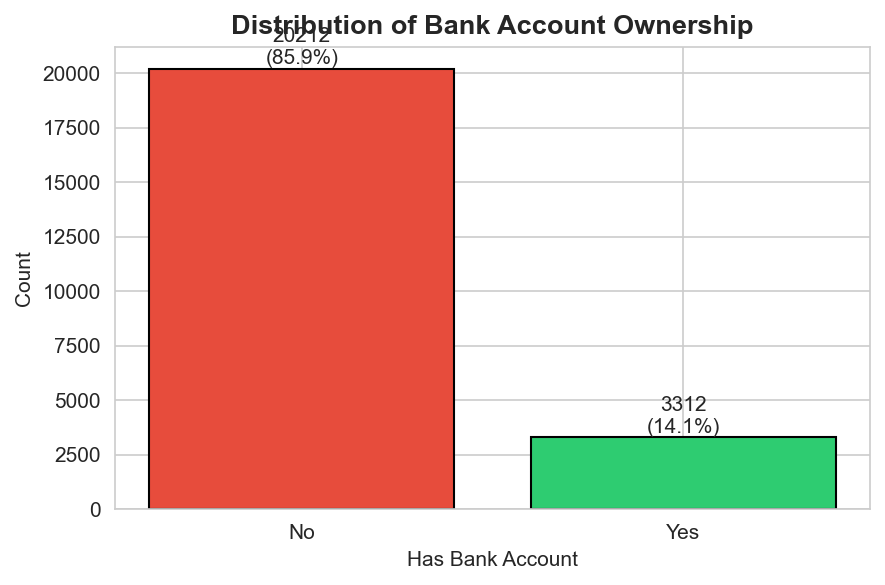

In [8]:
# Target distribution
fig, ax = plt.subplots(figsize=(6, 4))
counts = df['bank_account'].value_counts()
bars = ax.bar(counts.index, counts.values, color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_title('Distribution of Bank Account Ownership', fontsize=13, fontweight='bold')
ax.set_ylabel('Count'); ax.set_xlabel('Has Bank Account')
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{val}\n({val/len(df)*100:.1f}%)', ha='center', fontsize=10)
plt.tight_layout()
# SAVE FIRST (most important)
fig.savefig("figures/fig01_target_distribution.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close(fig)

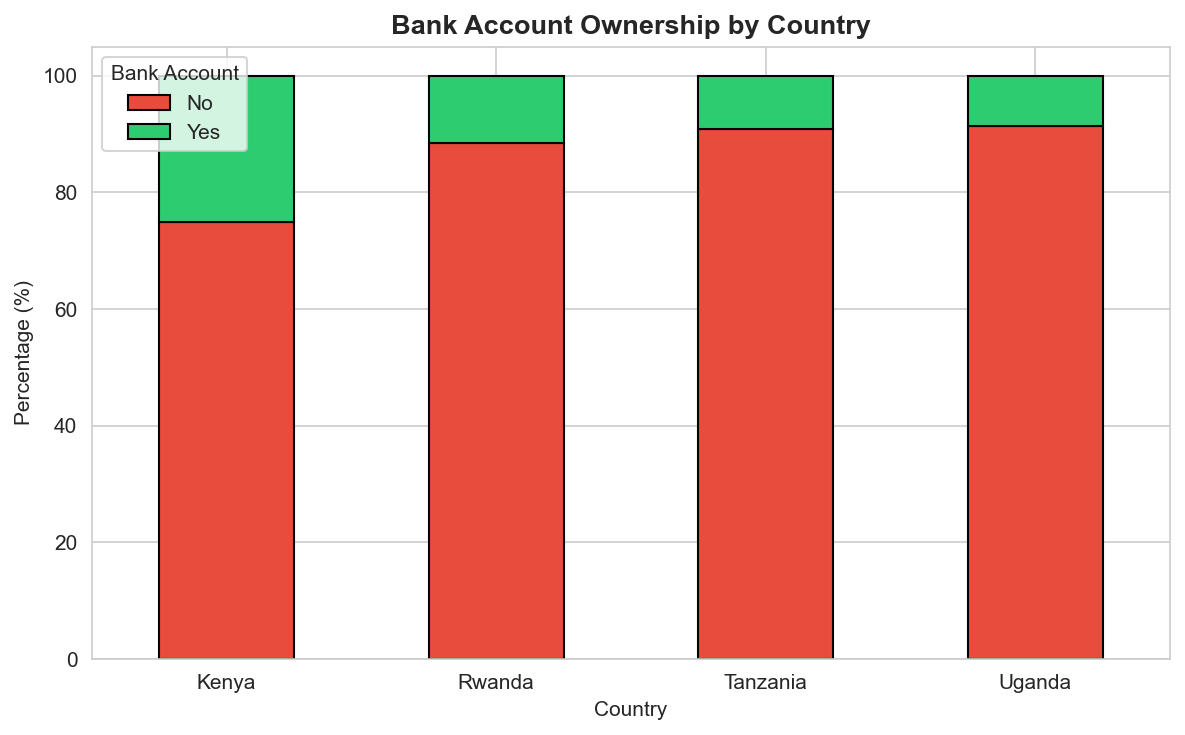

In [9]:
# Bank account by country
fig, ax = plt.subplots(figsize=(8, 5))
ct = pd.crosstab(df['country'], df['bank_account'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, ax=ax, color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_title('Bank Account Ownership by Country', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage (%)'); ax.set_xlabel('Country')
ax.legend(['No', 'Yes'], title='Bank Account')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout(); 
fig.savefig("figures/fig02_Bank_account_by_country.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

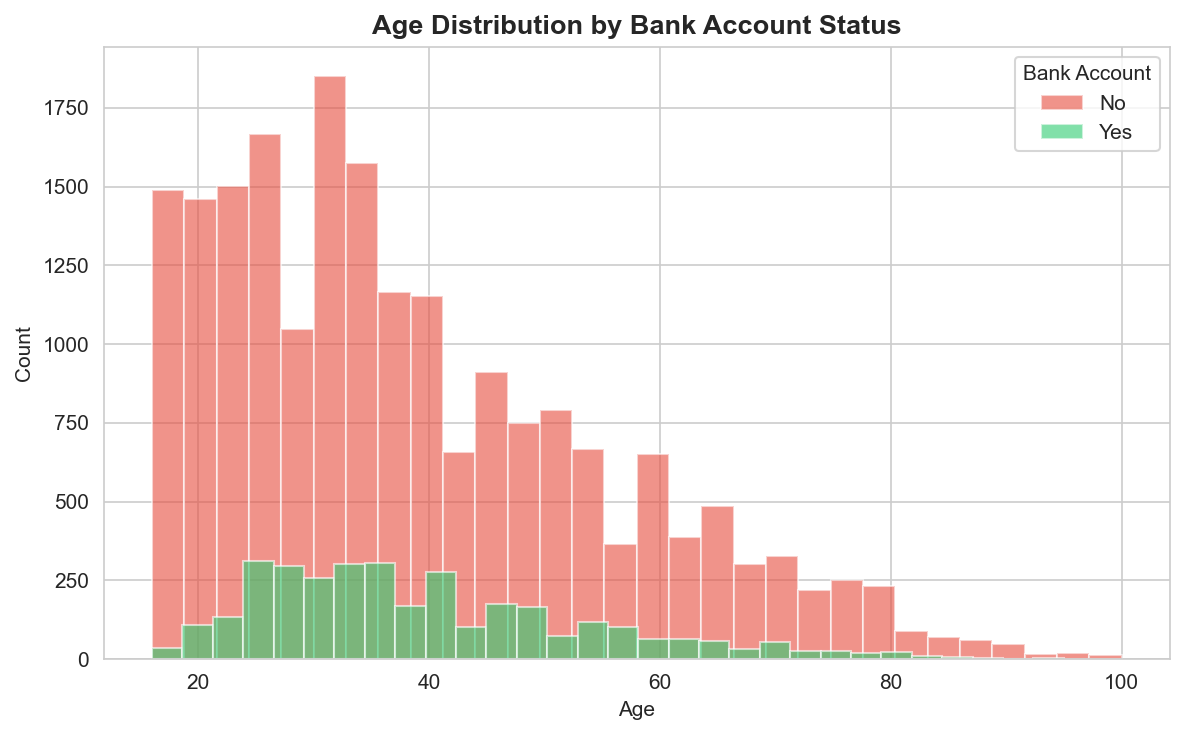

In [10]:
# Age distribution by bank account
fig, ax = plt.subplots(figsize=(8, 5))
df[df['bank_account']=='No']['age_of_respondent'].hist(bins=30, alpha=0.6, label='No', color='#e74c3c', ax=ax)
df[df['bank_account']=='Yes']['age_of_respondent'].hist(bins=30, alpha=0.6, label='Yes', color='#2ecc71', ax=ax)
ax.set_title('Age Distribution by Bank Account Status', fontsize=13, fontweight='bold')
ax.set_xlabel('Age'); ax.set_ylabel('Count'); ax.legend(title='Bank Account')
plt.tight_layout(); 
fig.savefig("figures/fig03_Age_Distribution_by_country.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

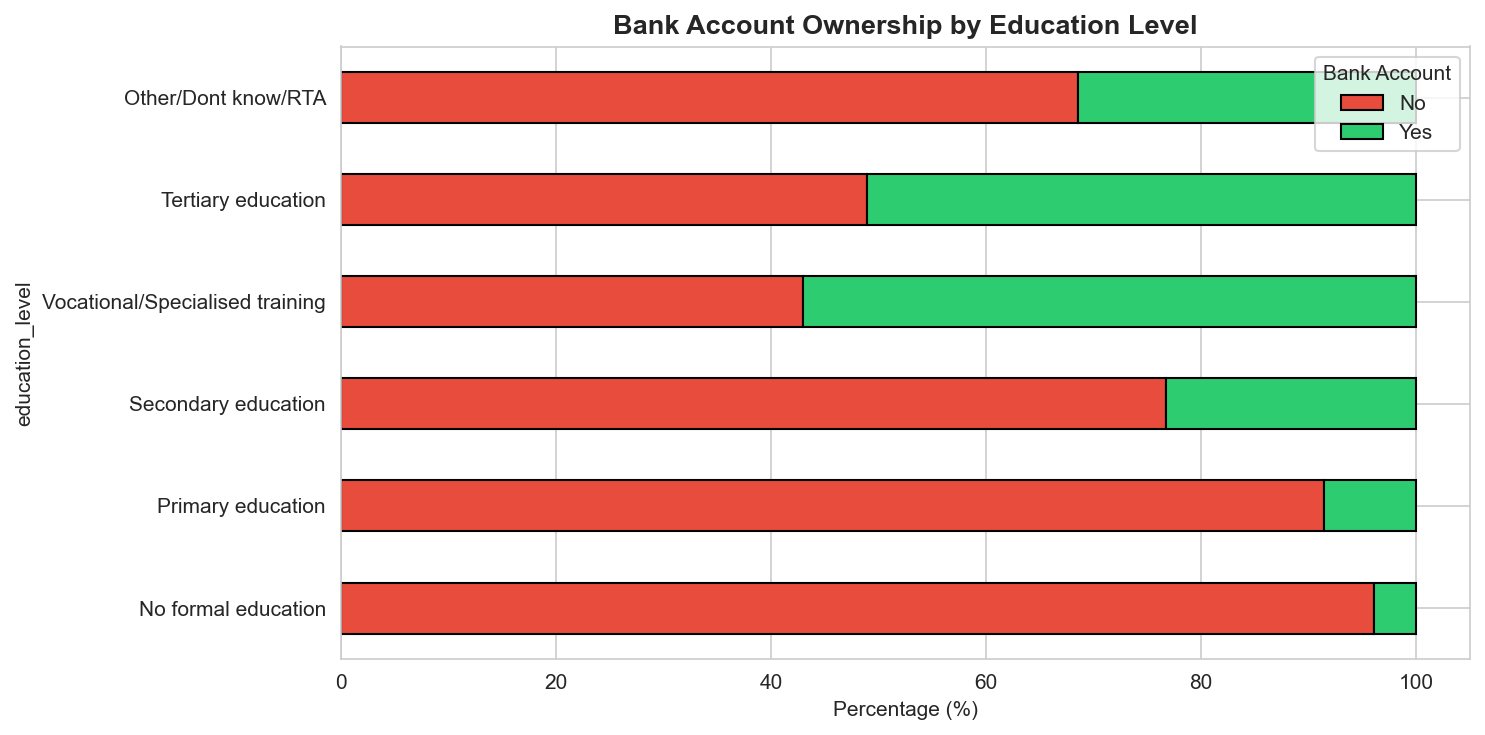

In [11]:
# Education level vs bank account
fig, ax = plt.subplots(figsize=(10, 5))
ct2 = pd.crosstab(df['education_level'], df['bank_account'], normalize='index') * 100
order = ['No formal education', 'Primary education', 'Secondary education',
         'Vocational/Specialised training', 'Tertiary education', 'Other/Dont know/RTA']
ct2 = ct2.reindex(order)
ct2.plot(kind='barh', stacked=True, ax=ax, color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_title('Bank Account Ownership by Education Level', fontsize=13, fontweight='bold')
ax.set_xlabel('Percentage (%)'); ax.legend(['No', 'Yes'], title='Bank Account')
plt.tight_layout(); 
fig.savefig("figures/fig04_Eduction_Level_VS_Account.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

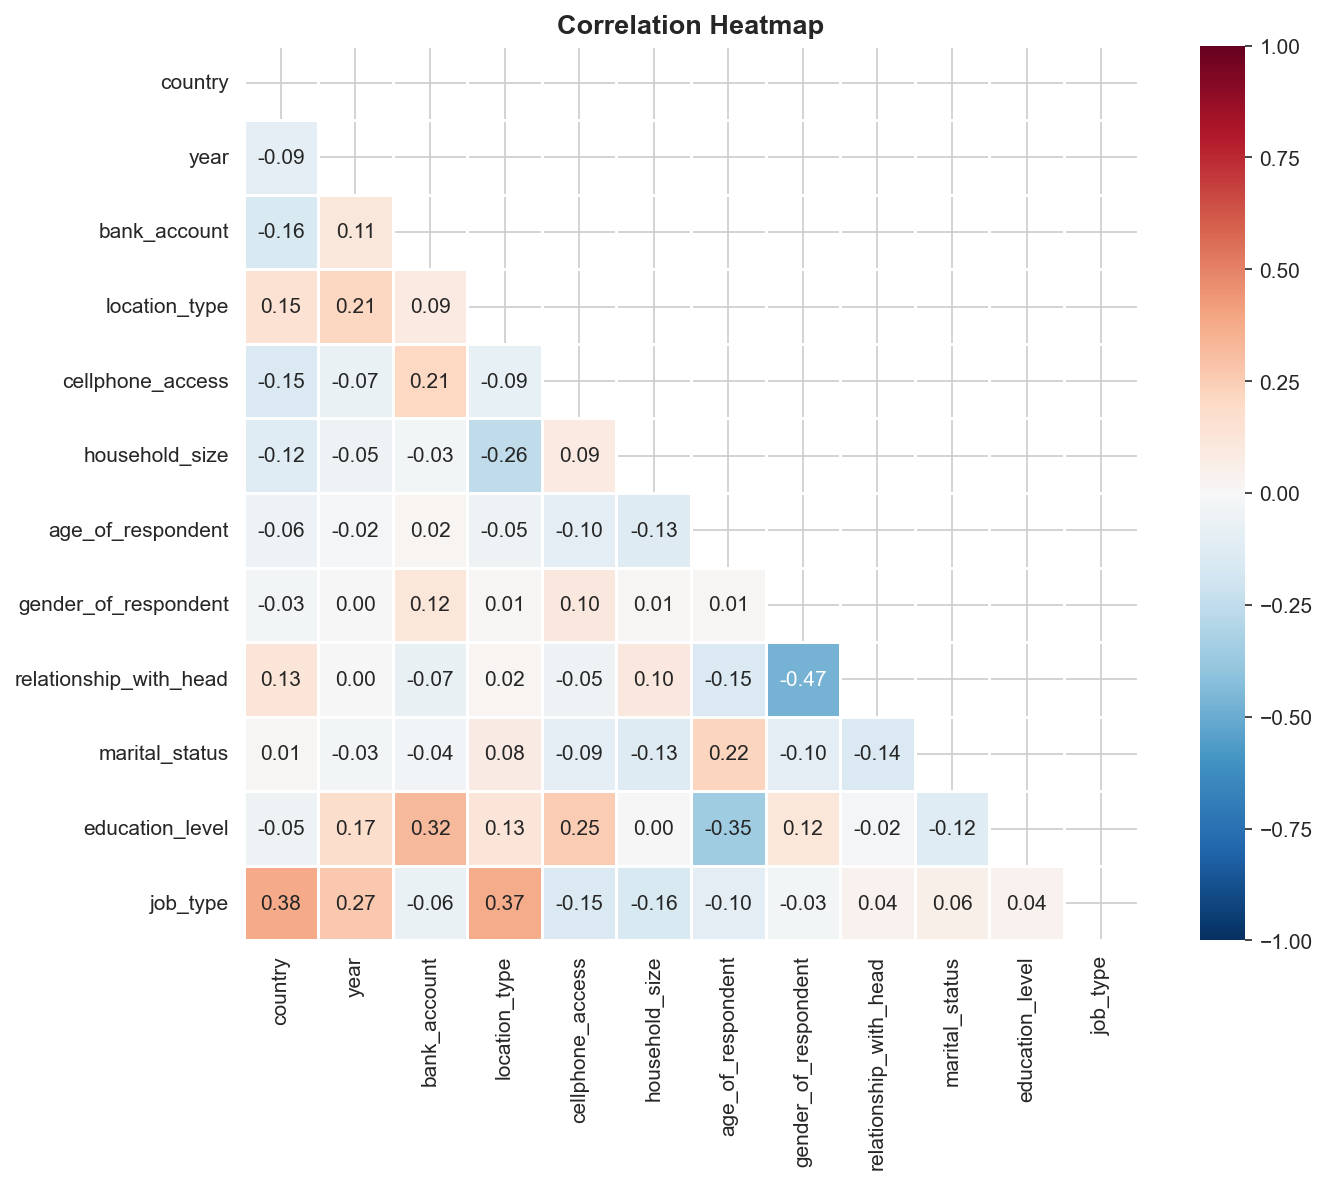

In [12]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap', fontsize=13, fontweight='bold')
plt.tight_layout(); 
fig.savefig("figures/fig05_Correlation.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

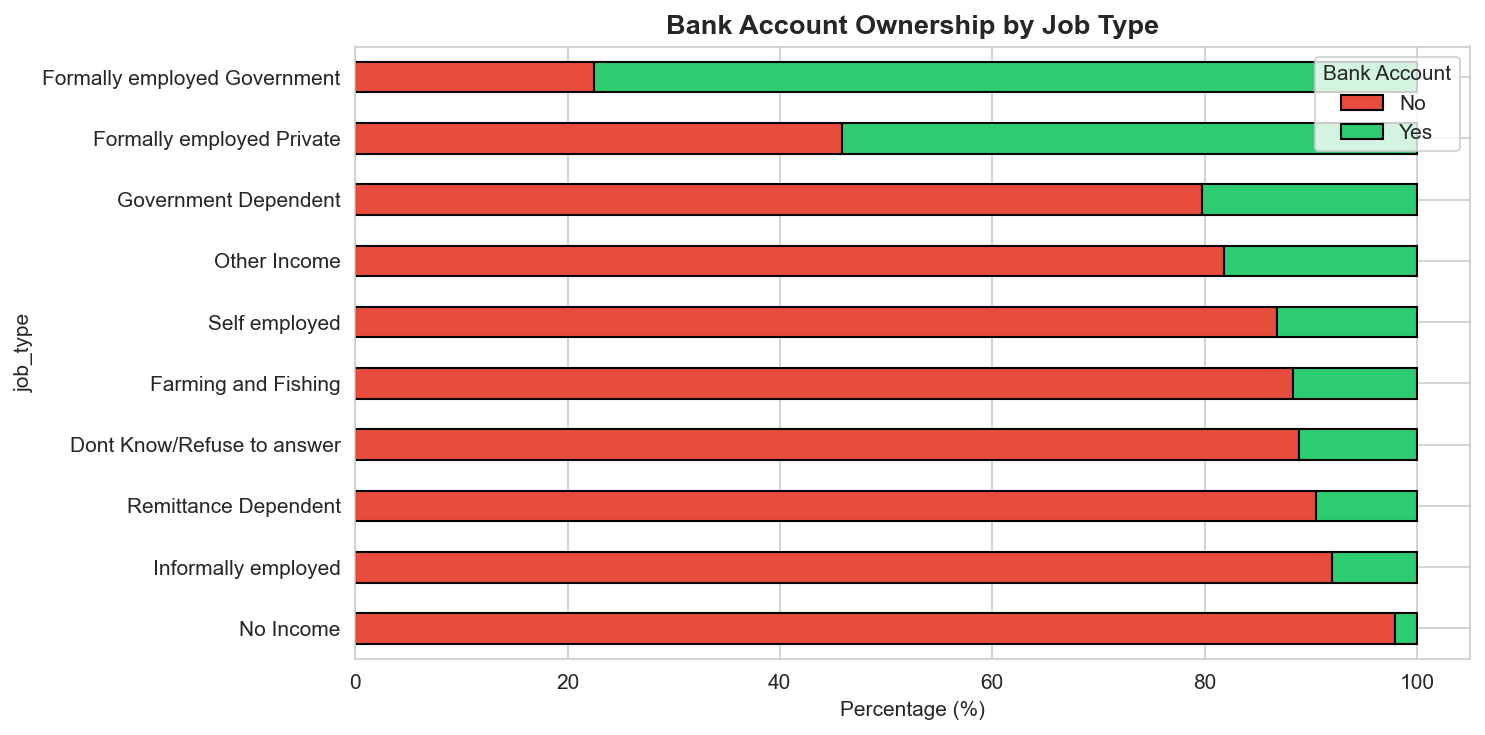

In [13]:
# Job type vs bank account
fig, ax = plt.subplots(figsize=(10, 5))
ct3 = pd.crosstab(df['job_type'], df['bank_account'], normalize='index') * 100
ct3 = ct3.sort_values('Yes', ascending=True)
ct3.plot(kind='barh', stacked=True, ax=ax, color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_title('Bank Account Ownership by Job Type', fontsize=13, fontweight='bold')
ax.set_xlabel('Percentage (%)'); ax.legend(['No', 'Yes'], title='Bank Account')
plt.tight_layout();
fig.savefig("figures/fig06_Job_VS_Bank_Account.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

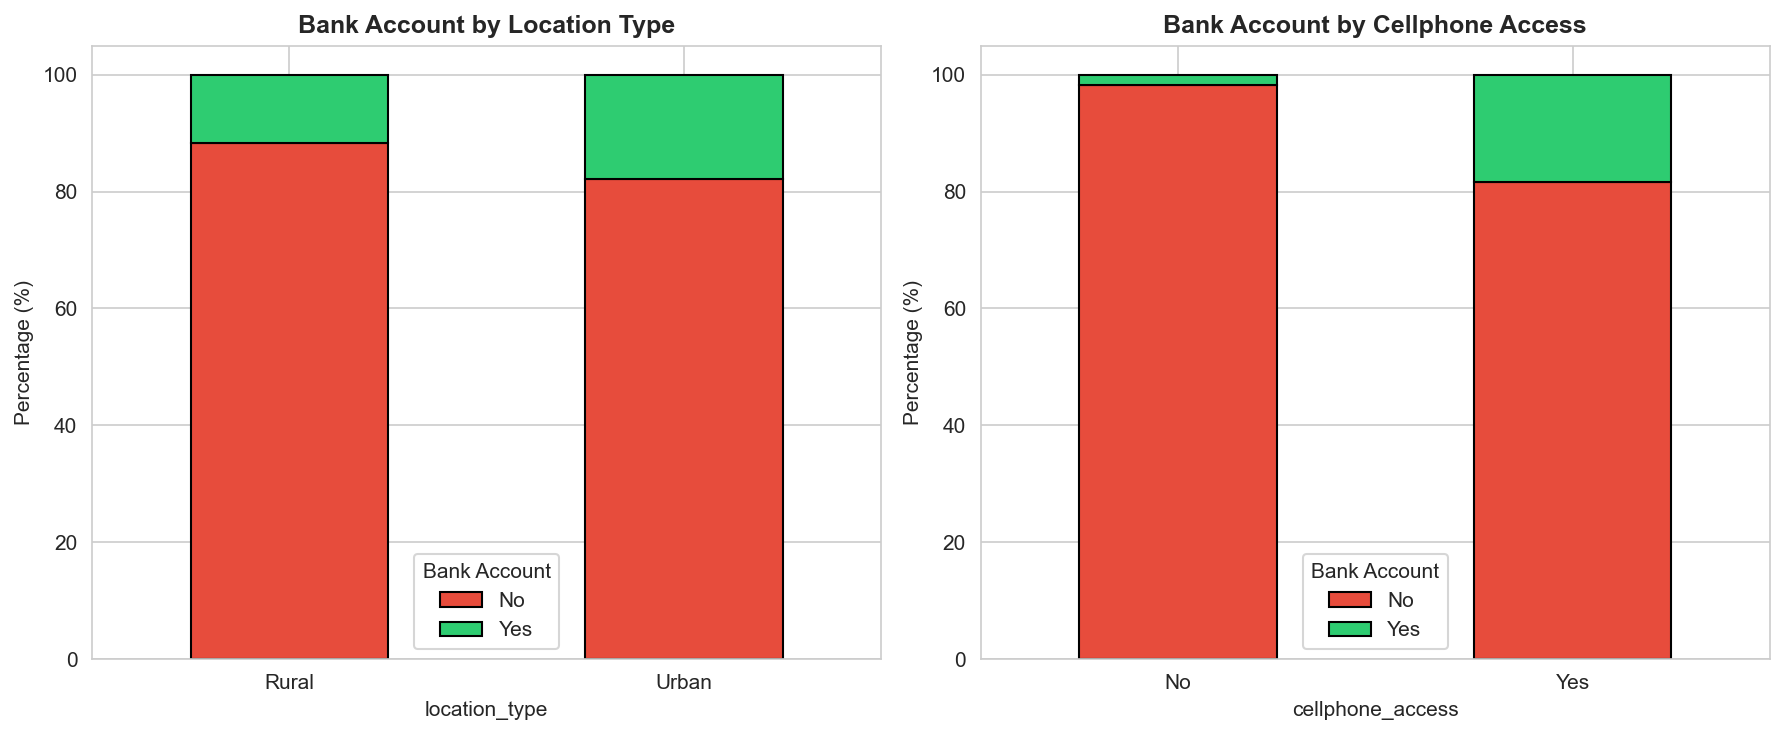

In [14]:
# Location type & cellphone access
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, col in enumerate(['location_type', 'cellphone_access']):
    ct4 = pd.crosstab(df[col], df['bank_account'], normalize='index') * 100
    ct4.plot(kind='bar', stacked=True, ax=axes[i], color=['#e74c3c', '#2ecc71'], edgecolor='black')
    axes[i].set_title(f'Bank Account by {col.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    axes[i].legend(['No', 'Yes'], title='Bank Account')
plt.tight_layout(); 
fig.savefig("figures/fig07_Loaction_Cellphone.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## 5. Classification: Baseline Models
**Objective:** Predict whether an individual has a bank account (binary classification)

**Algorithms:** Logistic Regression, Random Forest, Gradient Boosting, MLP Neural Network (Deep Learning)

In [15]:
# Prepare features and target
X = df_clean.drop(columns=['bank_account'])
y = df_clean['bank_account']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Target balance - Train: {y_train.value_counts(normalize=True).to_dict()}')

Train: (18819, 11), Test: (4705, 11)
Target balance - Train: {0: 0.8591848663584675, 1: 0.1408151336415325}


In [16]:
# ===== MODEL 1: LOGISTIC REGRESSION =====
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
print('=== Logistic Regression ===')
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4043
           1       0.65      0.23      0.34       662

    accuracy                           0.87      4705
   macro avg       0.77      0.60      0.63      4705
weighted avg       0.85      0.87      0.85      4705



In [17]:
# ===== MODEL 2: RANDOM FOREST =====
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
print('=== Random Forest ===')
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4043
           1       0.66      0.38      0.49       662

    accuracy                           0.89      4705
   macro avg       0.78      0.68      0.71      4705
weighted avg       0.87      0.89      0.87      4705



In [18]:
# ===== MODEL 3: GRADIENT BOOSTING =====
gb = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]
print('=== Gradient Boosting ===')
print(classification_report(y_test, y_pred_gb))

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4043
           1       0.67      0.39      0.49       662

    accuracy                           0.89      4705
   macro avg       0.79      0.68      0.71      4705
weighted avg       0.87      0.89      0.87      4705



In [19]:
# ===== MODEL 4: MLP NEURAL NETWORK (DEEP LEARNING) =====
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                    max_iter=300, random_state=42, early_stopping=True,
                    validation_fraction=0.1, learning_rate='adaptive')
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
y_prob_mlp = mlp.predict_proba(X_test_scaled)[:, 1]
print('=== MLP Neural Network (Deep Learning) ===')
print(classification_report(y_test, y_pred_mlp))

=== MLP Neural Network (Deep Learning) ===
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      4043
           1       0.67      0.36      0.47       662

    accuracy                           0.89      4705
   macro avg       0.79      0.67      0.70      4705
weighted avg       0.87      0.89      0.87      4705



## 6. Model Evaluation and Comparison

In [20]:
# Compile results
results = {}
for name, y_pred, y_prob in [('Logistic Regression', y_pred_lr, y_prob_lr),
                              ('Random Forest', y_pred_rf, y_prob_rf),
                              ('Gradient Boosting', y_pred_gb, y_prob_gb),
                              ('MLP Neural Network', y_pred_mlp, y_prob_mlp)]:
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }

results_df = pd.DataFrame(results).T.round(4)
print('\n===== BASELINE MODEL COMPARISON =====')
results_df


===== BASELINE MODEL COMPARISON =====


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Logistic Regression,0.8740,0.6494,0.2266,0.3359,0.8357
Random Forest,0.8857,0.6615,0.3837,0.4857,0.8657
Gradient Boosting,0.8871,0.6719,0.3867,0.4909,0.8739
MLP Neural Network,0.8850,0.6685,0.3625,0.4701,0.8638


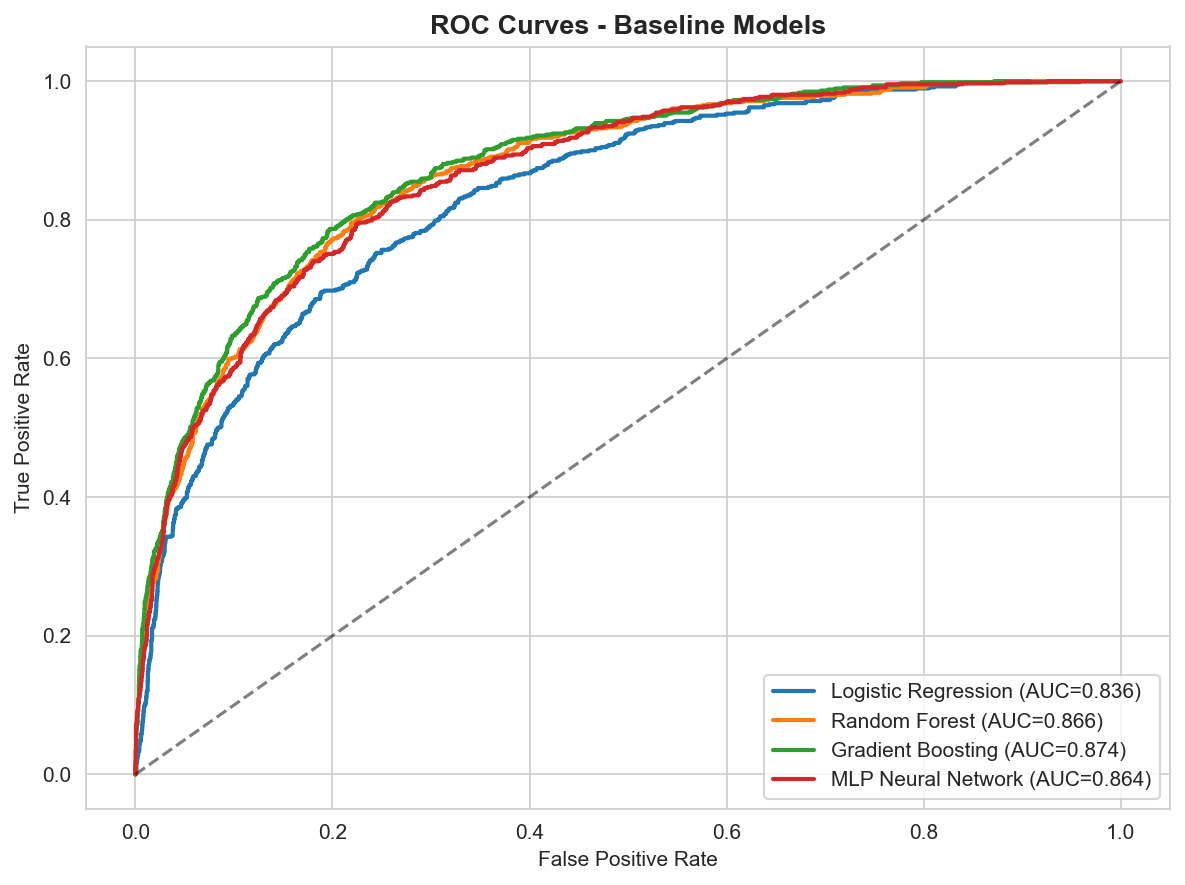

In [21]:
# ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))
for name, y_prob in [('Logistic Regression', y_prob_lr), ('Random Forest', y_prob_rf),
                      ('Gradient Boosting', y_prob_gb), ('MLP Neural Network', y_prob_mlp)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
ax.plot([0,1], [0,1], 'k--', alpha=0.5)
ax.set_title('ROC Curves - Baseline Models', fontsize=13, fontweight='bold')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.tight_layout(); 
fig.savefig("figures/fig08_ROC_Curves.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

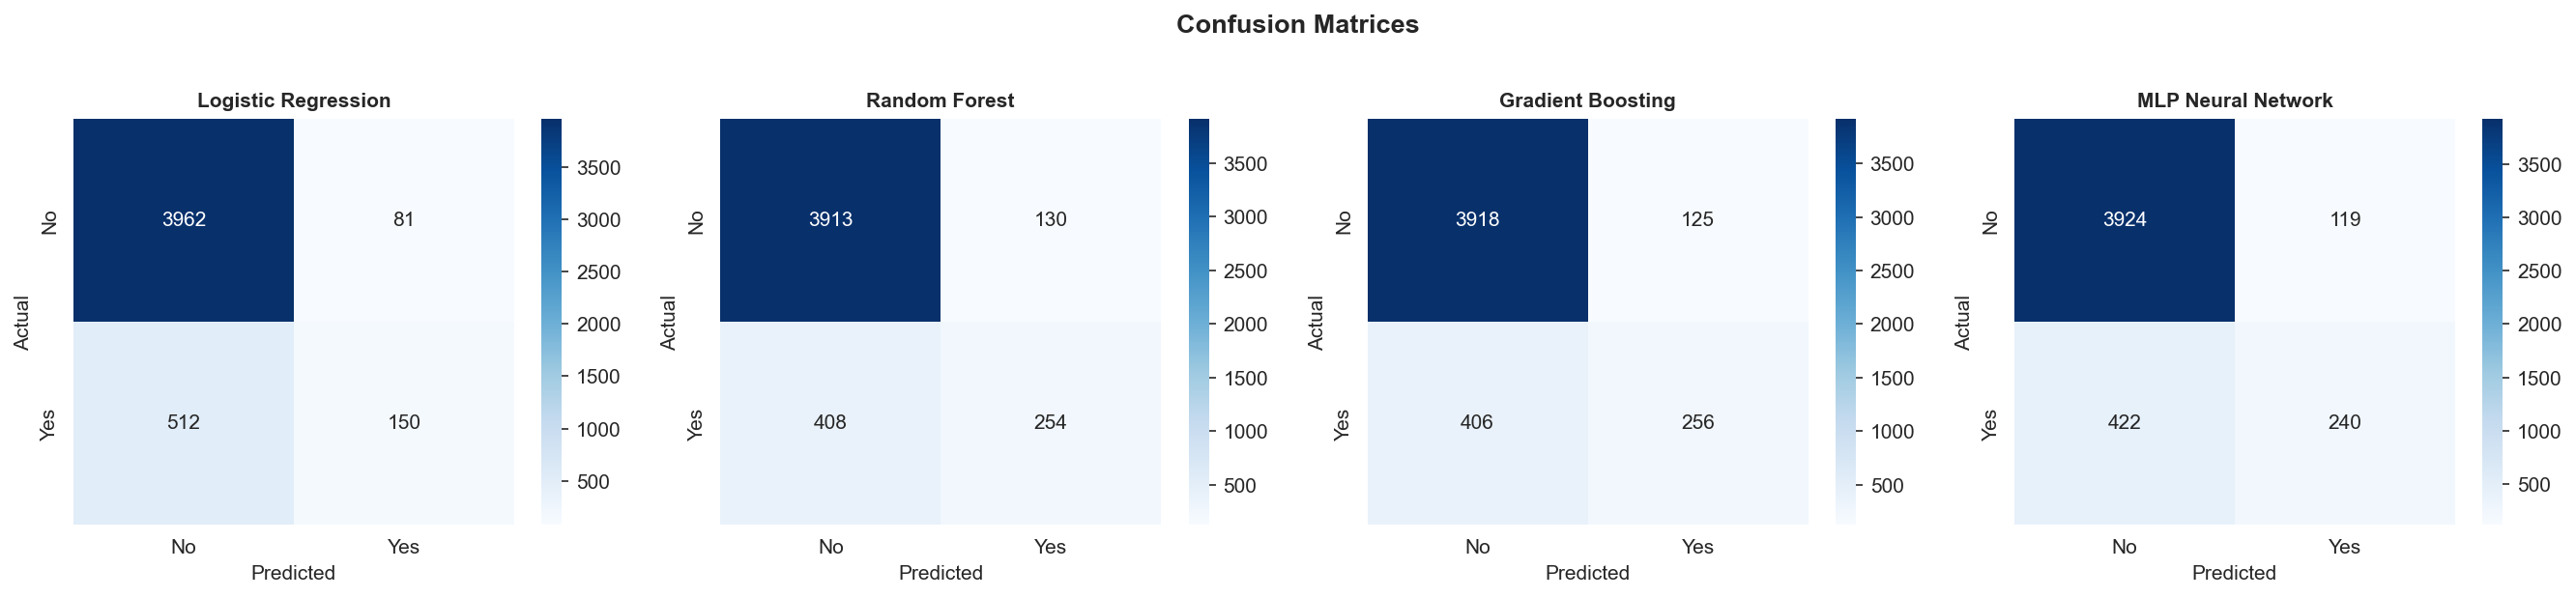

In [22]:
# Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, (name, y_pred) in enumerate([('Logistic Regression', y_pred_lr), ('Random Forest', y_pred_rf),
                                      ('Gradient Boosting', y_pred_gb), ('MLP Neural Network', y_pred_mlp)]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    axes[i].set_title(name, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Predicted'); axes[i].set_ylabel('Actual')
plt.suptitle('Confusion Matrices', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout(); 
fig.savefig("figures/fig09_Confusion_Matrix.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

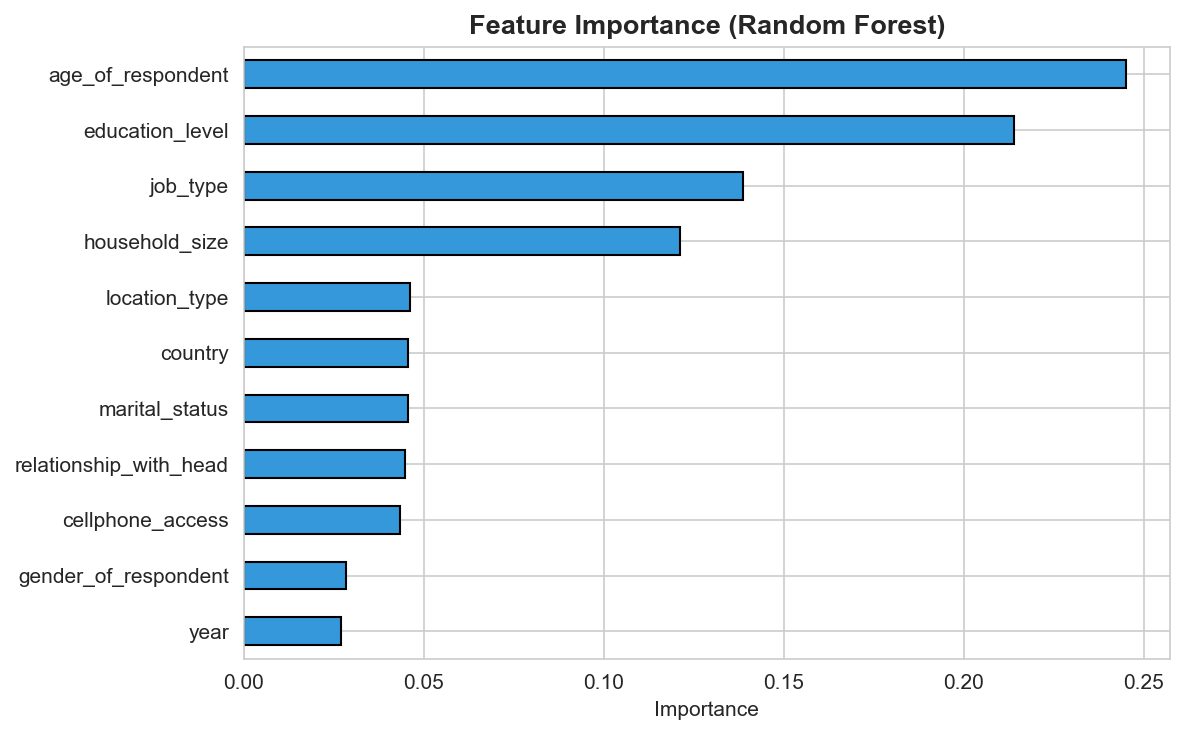

In [23]:
# Feature Importance
fig, ax = plt.subplots(figsize=(8, 5))
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh', ax=ax, color='#3498db', edgecolor='black')
ax.set_title('Feature Importance (Random Forest)', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance')
plt.tight_layout();
fig.savefig("figures/fig10_Feature_Importane.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## 7. Model Improvement
**Method:** Random oversampling to address class imbalance + class weighting + hyperparameter tuning

In [24]:
# Random Oversampling to balance classes
minority_idx = y_train[y_train == 1].index
majority_idx = y_train[y_train == 0].index
n_to_add = len(majority_idx) - len(minority_idx)

np.random.seed(42)
oversample_idx = np.random.choice(minority_idx, size=n_to_add, replace=True)

X_train_bal = pd.concat([X_train, X_train.loc[oversample_idx]])
y_train_bal = pd.concat([y_train, y_train.loc[oversample_idx]])

scaler2 = StandardScaler()
X_train_bal_scaled = scaler2.fit_transform(X_train_bal)
X_test_scaled2 = scaler2.transform(X_test)

print(f'Original train: {len(X_train)}, Balanced: {len(X_train_bal)}')
print(f'Class 0: {(y_train_bal==0).sum()}, Class 1: {(y_train_bal==1).sum()}')

Original train: 18819, Balanced: 32338
Class 0: 16169, Class 1: 16169


In [25]:
# Improved Models
# LR with class_weight='balanced'
lr_imp = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', C=0.5)
lr_imp.fit(X_train_scaled, y_train)
y_pred_lr_imp = lr_imp.predict(X_test_scaled)
y_prob_lr_imp = lr_imp.predict_proba(X_test_scaled)[:, 1]

# RF with class_weight + tuned
rf_imp = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5,
                                 class_weight='balanced_subsample', random_state=42, n_jobs=-1)
rf_imp.fit(X_train, y_train)
y_pred_rf_imp = rf_imp.predict(X_test)
y_prob_rf_imp = rf_imp.predict_proba(X_test)[:, 1]

# GB on balanced data
gb_imp = GradientBoostingClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                                     subsample=0.8, min_samples_split=10, random_state=42)
gb_imp.fit(X_train_bal, y_train_bal)
y_pred_gb_imp = gb_imp.predict(X_test)
y_prob_gb_imp = gb_imp.predict_proba(X_test)[:, 1]

# MLP on balanced data with deeper architecture
mlp_imp = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), activation='relu', solver='adam',
                         max_iter=500, random_state=42, early_stopping=True,
                         validation_fraction=0.15, learning_rate='adaptive', alpha=0.001, batch_size=64)
mlp_imp.fit(X_train_bal_scaled, y_train_bal)
y_pred_mlp_imp = mlp_imp.predict(X_test_scaled2)
y_prob_mlp_imp = mlp_imp.predict_proba(X_test_scaled2)[:, 1]

print('All improved models trained!')

All improved models trained!


## 8. Baseline vs Improved Comparison

In [26]:
# Compile improved results
improved_results = {}
for name, y_pred, y_prob in [('Logistic Regression', y_pred_lr_imp, y_prob_lr_imp),
                              ('Random Forest', y_pred_rf_imp, y_prob_rf_imp),
                              ('Gradient Boosting', y_pred_gb_imp, y_prob_gb_imp),
                              ('MLP Neural Network', y_pred_mlp_imp, y_prob_mlp_imp)]:
    improved_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }

imp_df = pd.DataFrame(improved_results).T.round(4)
print('===== IMPROVED MODEL RESULTS =====')
print(imp_df.to_string())

print('\n===== IMPROVEMENT (F1-Score) =====')
for model in results:
    base_f1 = results[model]['F1-Score']
    imp_f1 = improved_results[model]['F1-Score']
    print(f'{model}: {base_f1:.4f} -> {imp_f1:.4f} (delta = {imp_f1-base_f1:+.4f})')

===== IMPROVED MODEL RESULTS =====
                     Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression    0.7320     0.3157  0.7749    0.4486   0.8362
Random Forest          0.8612     0.5062  0.5544    0.5292   0.8546
Gradient Boosting      0.8140     0.4106  0.7387    0.5278   0.8673
MLP Neural Network     0.8168     0.4023  0.6224    0.4887   0.8160

===== IMPROVEMENT (F1-Score) =====
Logistic Regression: 0.3359 -> 0.4486 (delta = +0.1127)
Random Forest: 0.4857 -> 0.5292 (delta = +0.0435)
Gradient Boosting: 0.4909 -> 0.5278 (delta = +0.0369)
MLP Neural Network: 0.4701 -> 0.4887 (delta = +0.0186)


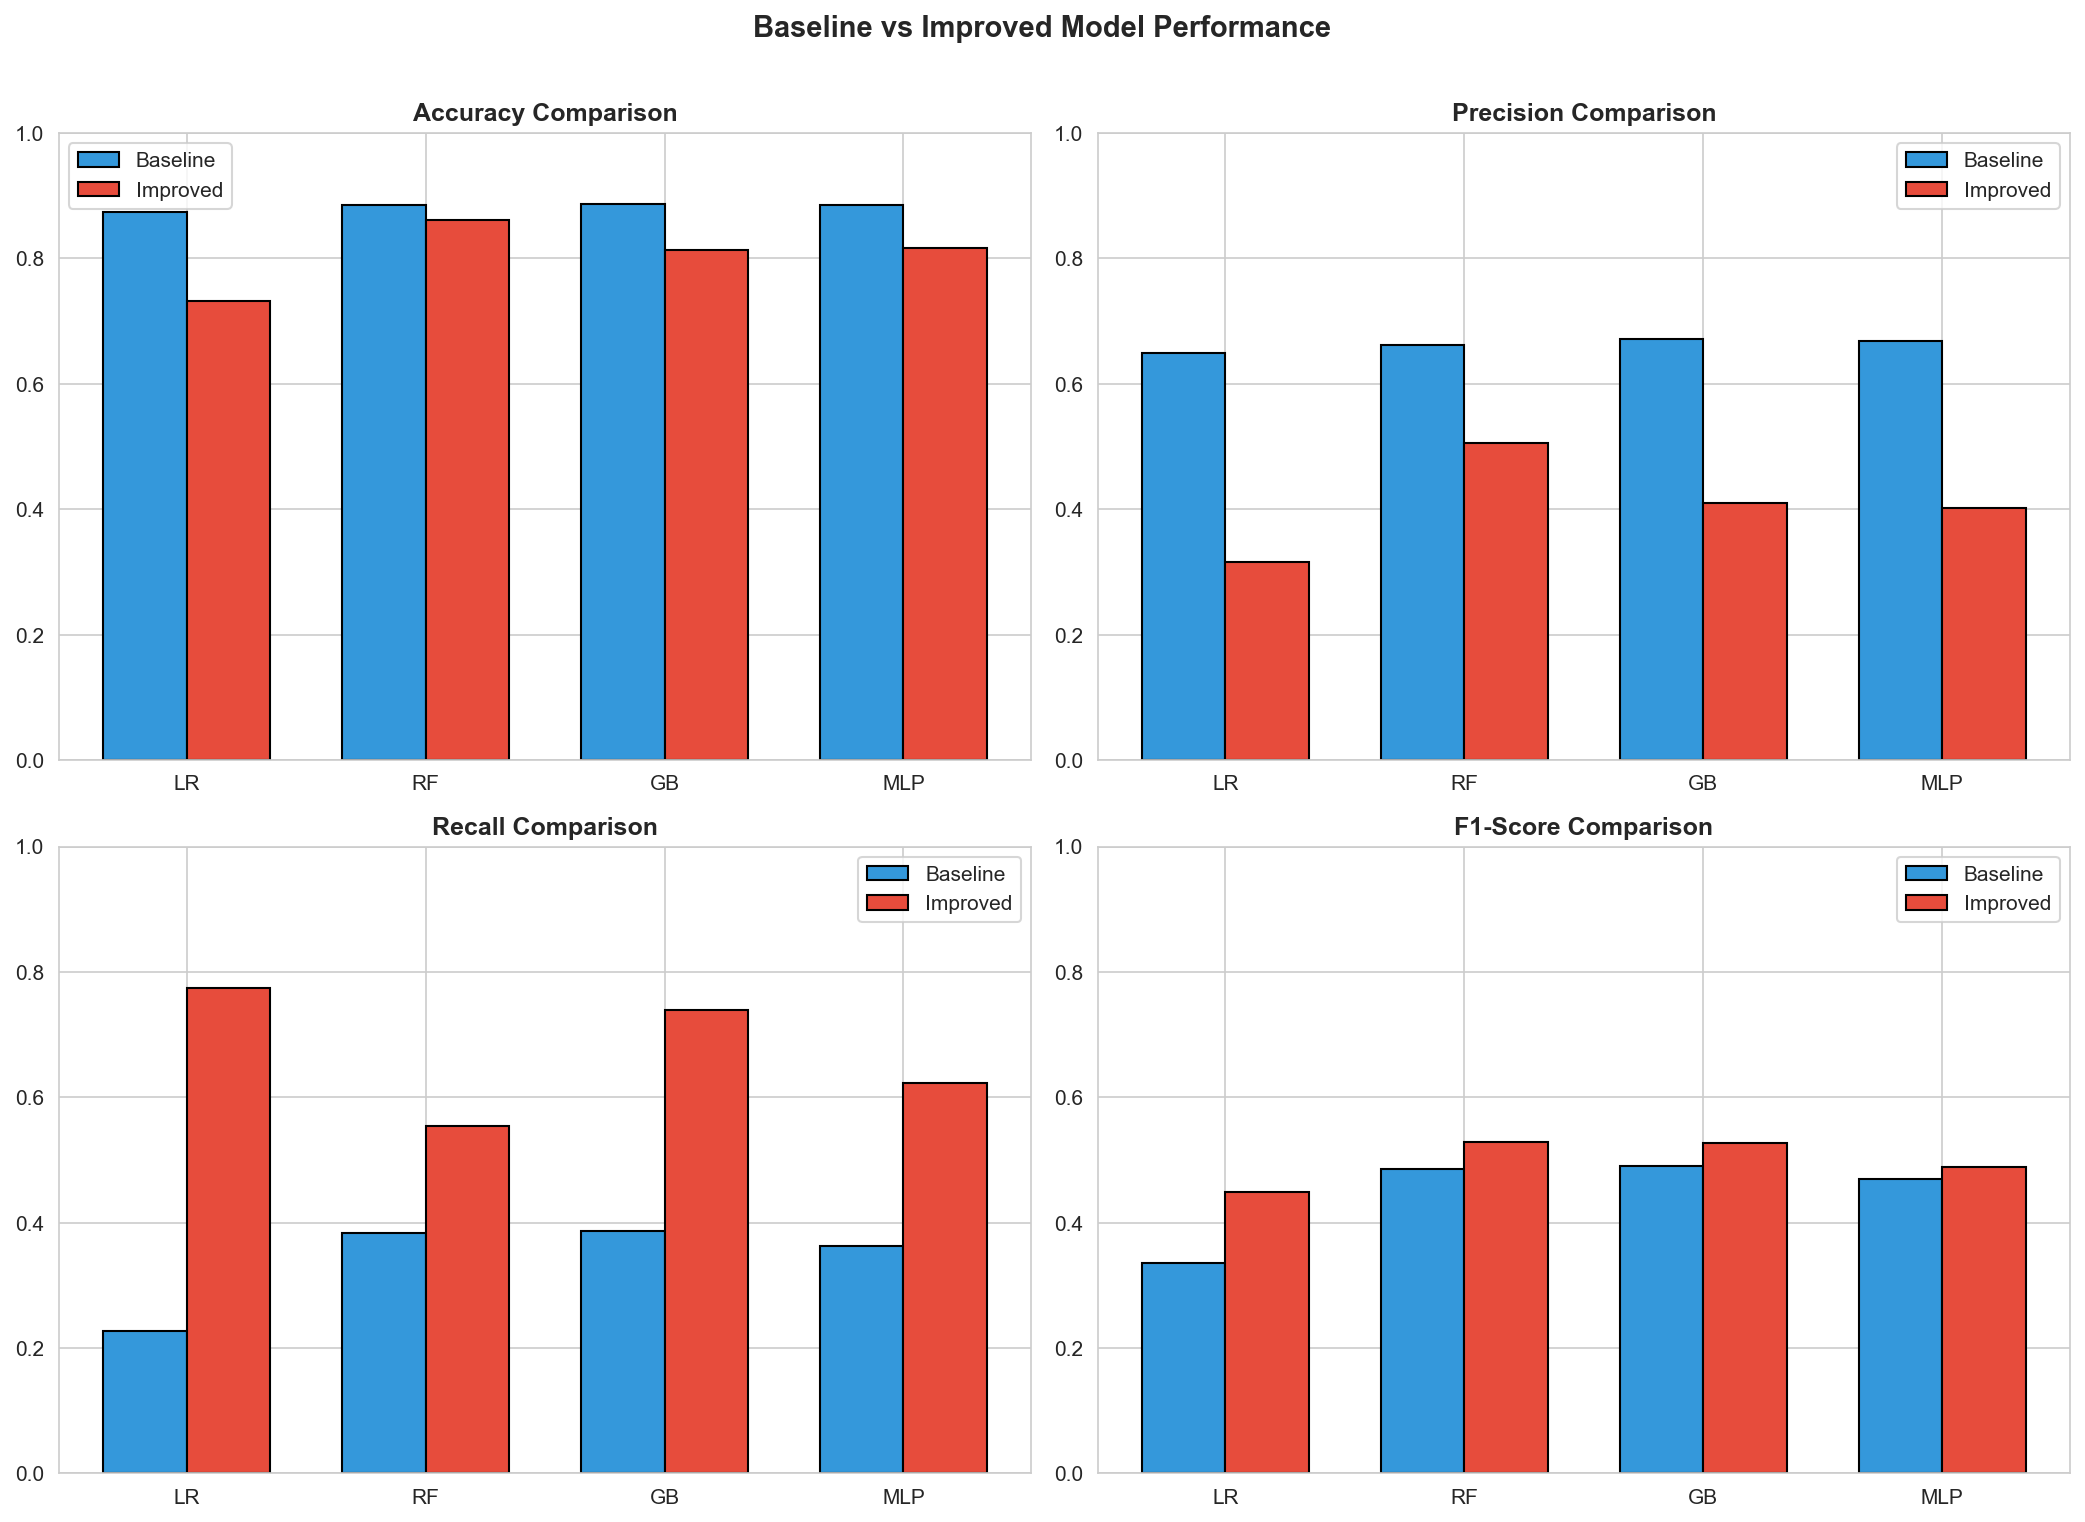

In [27]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
models = list(results.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models)); width = 0.35

for i, metric in enumerate(metrics):
    base_vals = [results[m][metric] for m in models]
    imp_vals = [improved_results[m][metric] for m in models]
    axes[i].bar(x - width/2, base_vals, width, label='Baseline', color='#3498db', edgecolor='black')
    axes[i].bar(x + width/2, imp_vals, width, label='Improved', color='#e74c3c', edgecolor='black')
    axes[i].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[i].set_xticks(x); axes[i].set_xticklabels(['LR', 'RF', 'GB', 'MLP'])
    axes[i].set_ylim(0, 1); axes[i].legend()
plt.suptitle('Baseline vs Improved Model Performance', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout();
fig.savefig("figures/fig11_Comparison.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

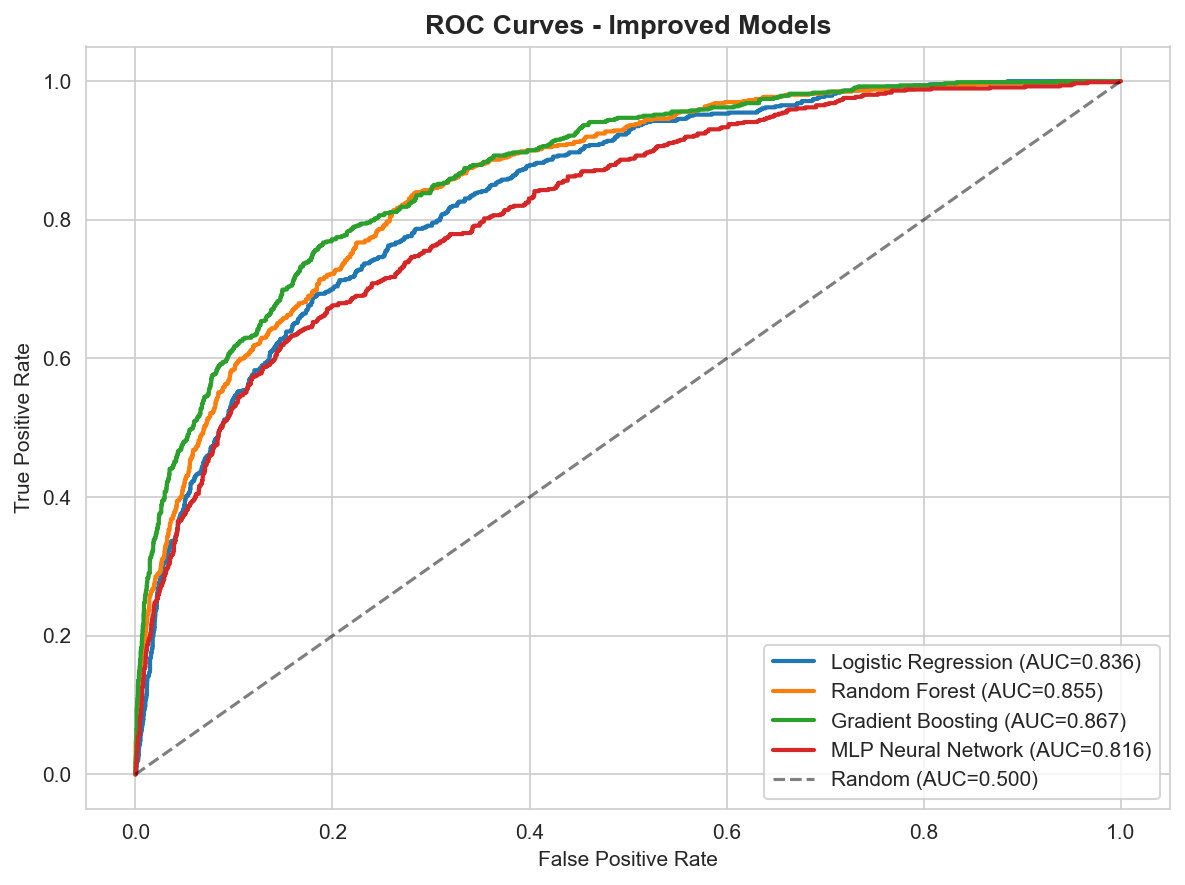

In [28]:
# ROC Curves for Improved Models
fig, ax = plt.subplots(figsize=(8, 6))
for name, y_prob in [('Logistic Regression', y_prob_lr_imp), ('Random Forest', y_prob_rf_imp),
                      ('Gradient Boosting', y_prob_gb_imp), ('MLP Neural Network', y_prob_mlp_imp)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.500)')
ax.set_title('ROC Curves - Improved Models', fontsize=13, fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.tight_layout()
fig.savefig("fig15_roc_curves_improved.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## 9. Clustering Analysis
**Algorithms:** K-Means, Hierarchical (Agglomerative) Clustering

K=2: Inertia=224384, Silhouette=0.1377
K=3: Inertia=199726, Silhouette=0.1642
K=4: Inertia=185713, Silhouette=0.1546
K=5: Inertia=172583, Silhouette=0.1462
K=6: Inertia=161970, Silhouette=0.1580
K=7: Inertia=152977, Silhouette=0.1692
K=8: Inertia=146501, Silhouette=0.1756
K=9: Inertia=140219, Silhouette=0.1723
K=10: Inertia=135421, Silhouette=0.1734


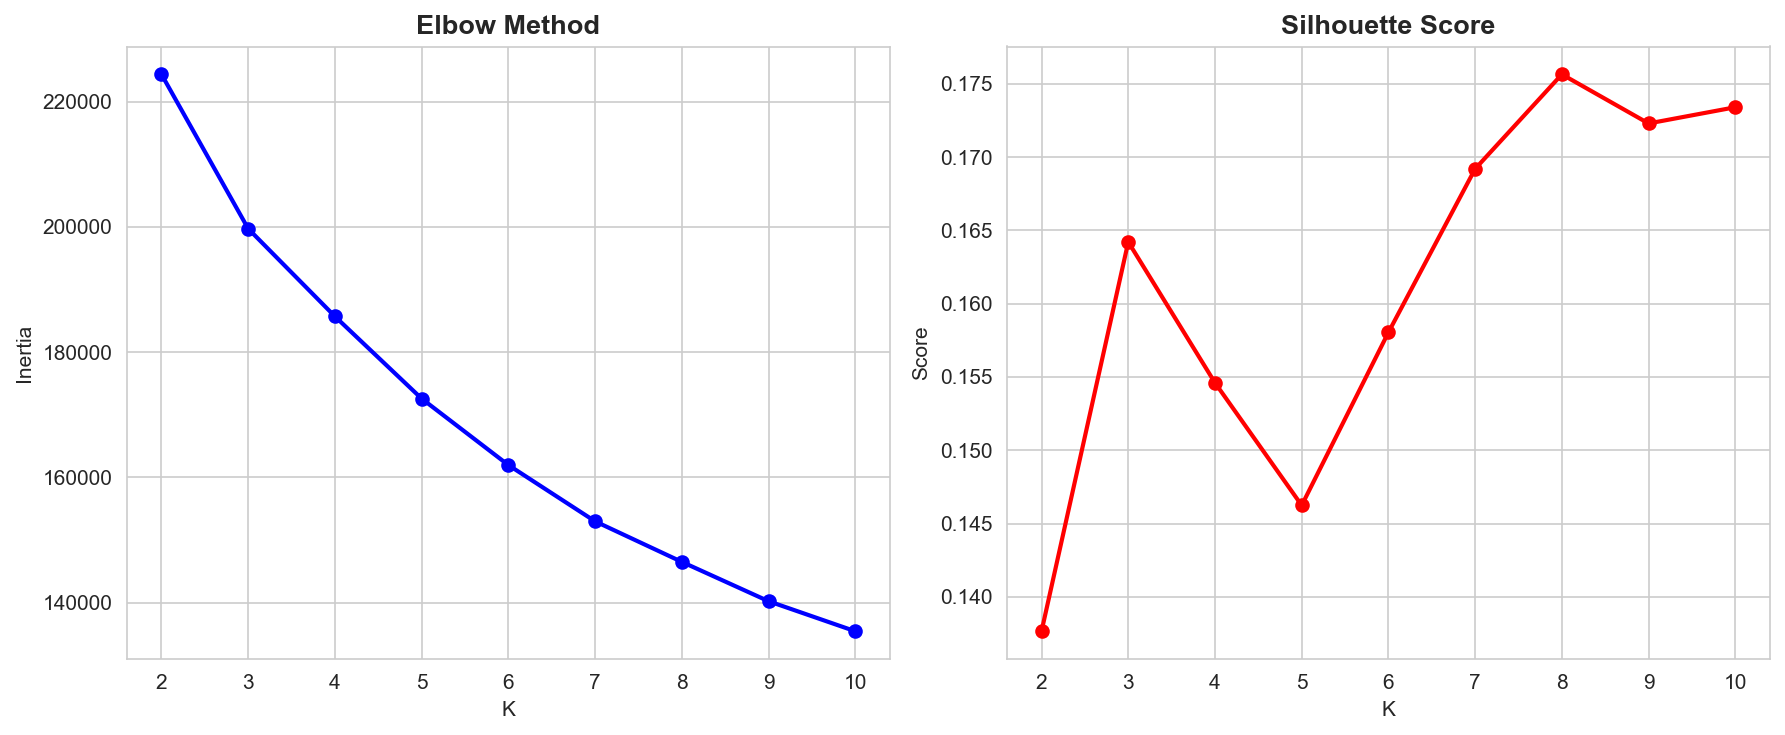

In [29]:
# Prepare data for clustering
X_cluster = df_clean.drop(columns=['bank_account'])
scaler_c = StandardScaler()
X_scaled = scaler_c.fit_transform(X_cluster)

# Elbow method + Silhouette
inertias, sil_scores = [], []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, km.labels_, sample_size=5000)
    sil_scores.append(sil)
    print(f'K={k}: Inertia={km.inertia_:.0f}, Silhouette={sil:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(list(K_range), inertias, 'bo-', linewidth=2)
axes[0].set_title('Elbow Method', fontsize=13, fontweight='bold')
axes[0].set_xlabel('K'); axes[0].set_ylabel('Inertia')
axes[1].plot(list(K_range), sil_scores, 'ro-', linewidth=2)
axes[1].set_title('Silhouette Score', fontsize=13, fontweight='bold')
axes[1].set_xlabel('K'); axes[1].set_ylabel('Score')
plt.tight_layout(); 
fig.savefig("figures/fig12_Clustering.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

K-Means Silhouette Score: 0.1591
Hierarchical Silhouette Score: 0.1575


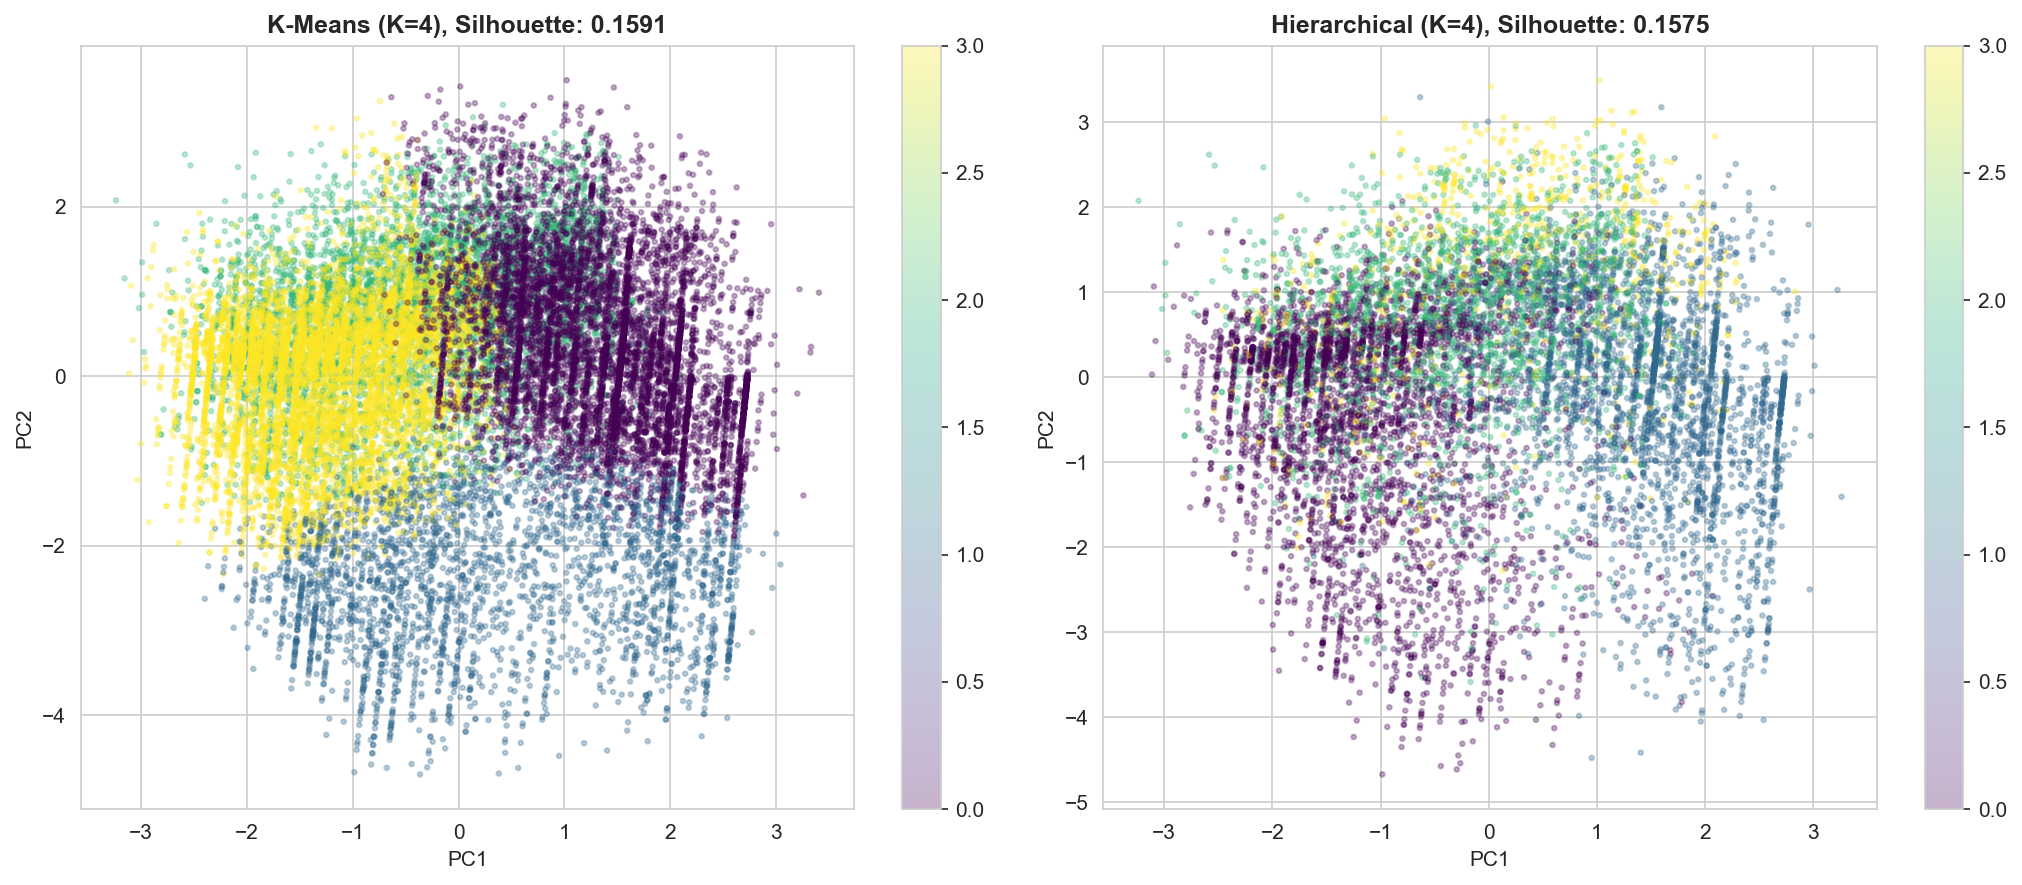

In [30]:
# K-Means with K=4
km_final = KMeans(n_clusters=4, random_state=42, n_init=20)
km_labels = km_final.fit_predict(X_scaled)
sil_km = silhouette_score(X_scaled, km_labels)
print(f'K-Means Silhouette Score: {sil_km:.4f}')

# Hierarchical Clustering (on sample for efficiency)
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), size=10000, replace=False)
X_sample = X_scaled[sample_idx]
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
hc_labels = hc.fit_predict(X_sample)
sil_hc = silhouette_score(X_sample, hc_labels)
print(f'Hierarchical Silhouette Score: {sil_hc:.4f}')

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
s1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap='viridis', alpha=0.3, s=5)
axes[0].set_title(f'K-Means (K=4), Silhouette: {sil_km:.4f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2'); plt.colorbar(s1, ax=axes[0])

X_pca_s = pca.transform(X_sample)
s2 = axes[1].scatter(X_pca_s[:, 0], X_pca_s[:, 1], c=hc_labels, cmap='viridis', alpha=0.3, s=5)
axes[1].set_title(f'Hierarchical (K=4), Silhouette: {sil_hc:.4f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2'); plt.colorbar(s2, ax=axes[1])
plt.tight_layout(); 
fig.savefig("figures/fig13_KMeans.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

In [31]:
# Cluster Profiles
df_clean['cluster'] = km_labels
profile = df_clean.groupby('cluster').mean().round(3)
print('\n=== Cluster Profiles ===')
profile


=== Cluster Profiles ===


,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
cluster,,,,,,,,,,,,
0,2.215,2017.215,0.097,0.644,0.676,3.126,33.232,0.403,2.742,2.307,2.215,7.706
1,1.260,2016.830,0.057,0.363,0.402,2.523,65.164,0.251,1.308,3.433,0.697,5.385
2,0.000,2018.000,0.263,0.442,0.832,4.128,36.302,0.449,1.992,2.235,2.477,4.962
3,1.041,2016.041,0.131,0.107,0.886,4.770,35.182,0.456,2.237,2.157,1.964,3.507


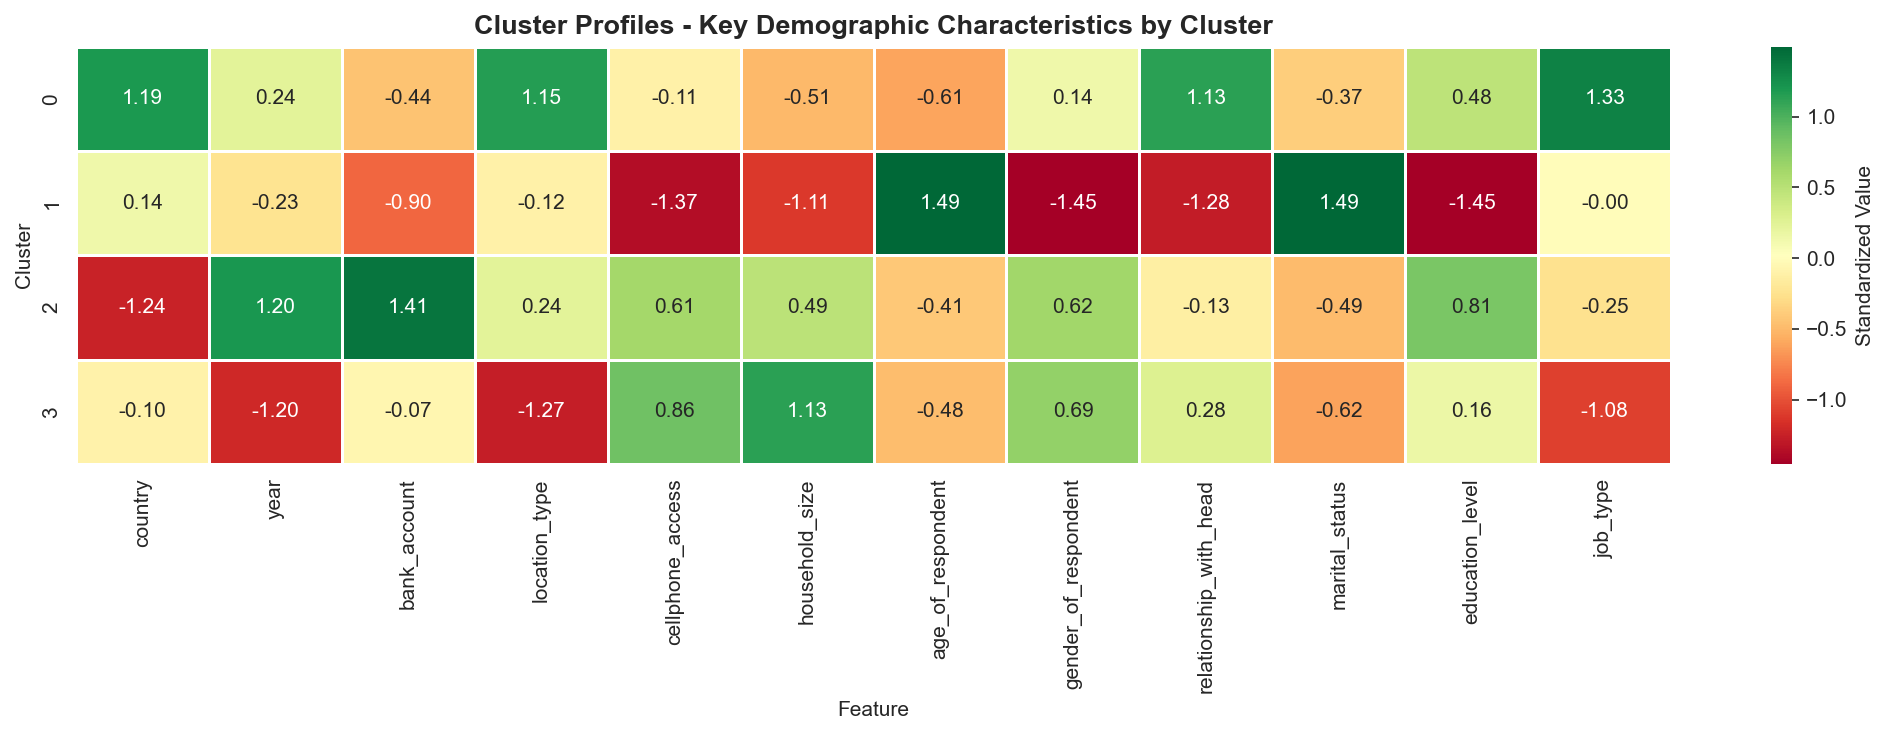

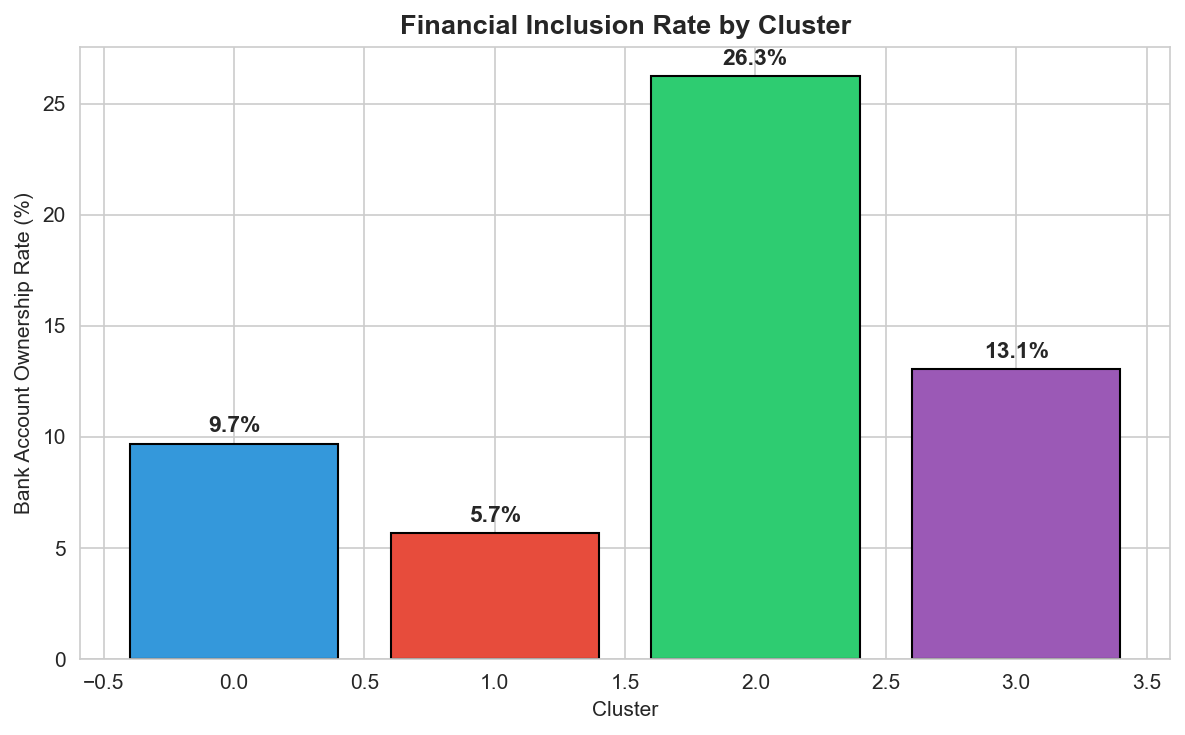

In [38]:
# Cluster Profiles Heatmap Visualization
profile = df_clean.groupby('cluster').mean()
profile_norm = (profile - profile.mean()) / profile.std()

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(profile_norm, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'Standardized Value'})
ax.set_title('Cluster Profiles - Key Demographic Characteristics by Cluster',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Cluster')
ax.set_xlabel('Feature')
plt.tight_layout()
fig.savefig("figures/fig16_Cluster_Profiles_Heatmap", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

# Bank account inclusion rate by cluster
fig, ax = plt.subplots(figsize=(8, 5))
inclusion_rate = df_clean.groupby('cluster')['bank_account'].mean() * 100
bars = ax.bar(inclusion_rate.index, inclusion_rate.values, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'],
              edgecolor='black')
ax.set_title('Financial Inclusion Rate by Cluster', fontsize=13, fontweight='bold')
ax.set_xlabel('Cluster')
ax.set_ylabel('Bank Account Ownership Rate (%)')
for bar, val in zip(bars, inclusion_rate.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
fig.savefig("figures/fig17_Financial_Inclusion_Rate_by_Cluseter.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## 11. Apply Best Model on Test Dataset
Now we apply the best performing model (Gradient Boosting) on the **Test.csv** dataset to generate predictions.

The Test.csv file does not contain the `bank_account` target column — it is the unseen data on which we apply our trained model.

In [32]:
# Load Test dataset
test_df = pd.read_csv('Test.csv')
print(f'Test dataset shape: {test_df.shape}')
print(f'\nColumns in Test: {list(test_df.columns)}')
print(f'\nNote: bank_account column is NOT present in Test.csv')
test_df.head()

Test dataset shape: (10086, 12)

Columns in Test: ['country', 'year', 'uniqueid', 'location_type', 'cellphone_access', 'household_size', 'age_of_respondent', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

Note: bank_account column is NOT present in Test.csv


,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [33]:
# Preprocess Test data (same steps as Train)
test_clean = test_df.copy()

# Save uniqueid and country for submission file
test_ids = test_clean['uniqueid']
test_countries = test_clean['country']

# Drop uniqueid
test_clean = test_clean.drop(columns=['uniqueid'])

# Label encode using same encoders as training
cat_cols = ['country', 'location_type', 'cellphone_access', 'gender_of_respondent',
            'relationship_with_head', 'marital_status', 'education_level', 'job_type']

for col in cat_cols:
    test_clean[col] = le_dict[col].transform(test_clean[col])

print(f'Preprocessed Test shape: {test_clean.shape}')
print(f'Columns: {list(test_clean.columns)}')
test_clean.head()

Preprocessed Test shape: (10086, 11)
Columns: ['country', 'year', 'location_type', 'cellphone_access', 'household_size', 'age_of_respondent', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']


,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,2018,1,1,3,30,1,1,2,3,2
1,0,2018,1,1,7,51,1,1,2,5,3
2,0,2018,0,0,3,77,0,4,2,0,8
3,0,2018,0,0,6,39,0,1,2,2,8
4,0,2018,1,0,3,16,1,0,3,3,8


In [34]:
# Generate predictions using the best improved model (Gradient Boosting)
test_predictions = gb_imp.predict(test_clean)
test_probabilities = gb_imp.predict_proba(test_clean)[:, 1]

print(f'Total predictions: {len(test_predictions)}')
print(f'\nPredicted distribution:')
print(f'  No bank account (0): {(test_predictions == 0).sum()} ({(test_predictions == 0).mean()*100:.1f}%)')
print(f'  Has bank account (1): {(test_predictions == 1).sum()} ({(test_predictions == 1).mean()*100:.1f}%)')

Total predictions: 10086

Predicted distribution:
  No bank account (0): 7554 (74.9%)
  Has bank account (1): 2532 (25.1%)


In [35]:
# Create submission file
submission = pd.DataFrame({
    'uniqueid': test_ids + ' x ' + test_countries,
    'bank_account': test_predictions
})

print('Submission file preview:')
print(submission.head(10))
print(f'\nSubmission shape: {submission.shape}')

# Save submission
submission.to_csv('submission.csv', index=False)
print('\nSubmission file saved as submission.csv')

Submission file preview:
                uniqueid  bank_account
0  uniqueid_6056 x Kenya             1
1  uniqueid_6060 x Kenya             1
2  uniqueid_6065 x Kenya             0
3  uniqueid_6072 x Kenya             0
4  uniqueid_6073 x Kenya             0
5  uniqueid_6074 x Kenya             0
6  uniqueid_6075 x Kenya             0
7  uniqueid_6076 x Kenya             1
8  uniqueid_6077 x Kenya             0
9  uniqueid_6078 x Kenya             1

Submission shape: (10086, 2)

Submission file saved as submission.csv


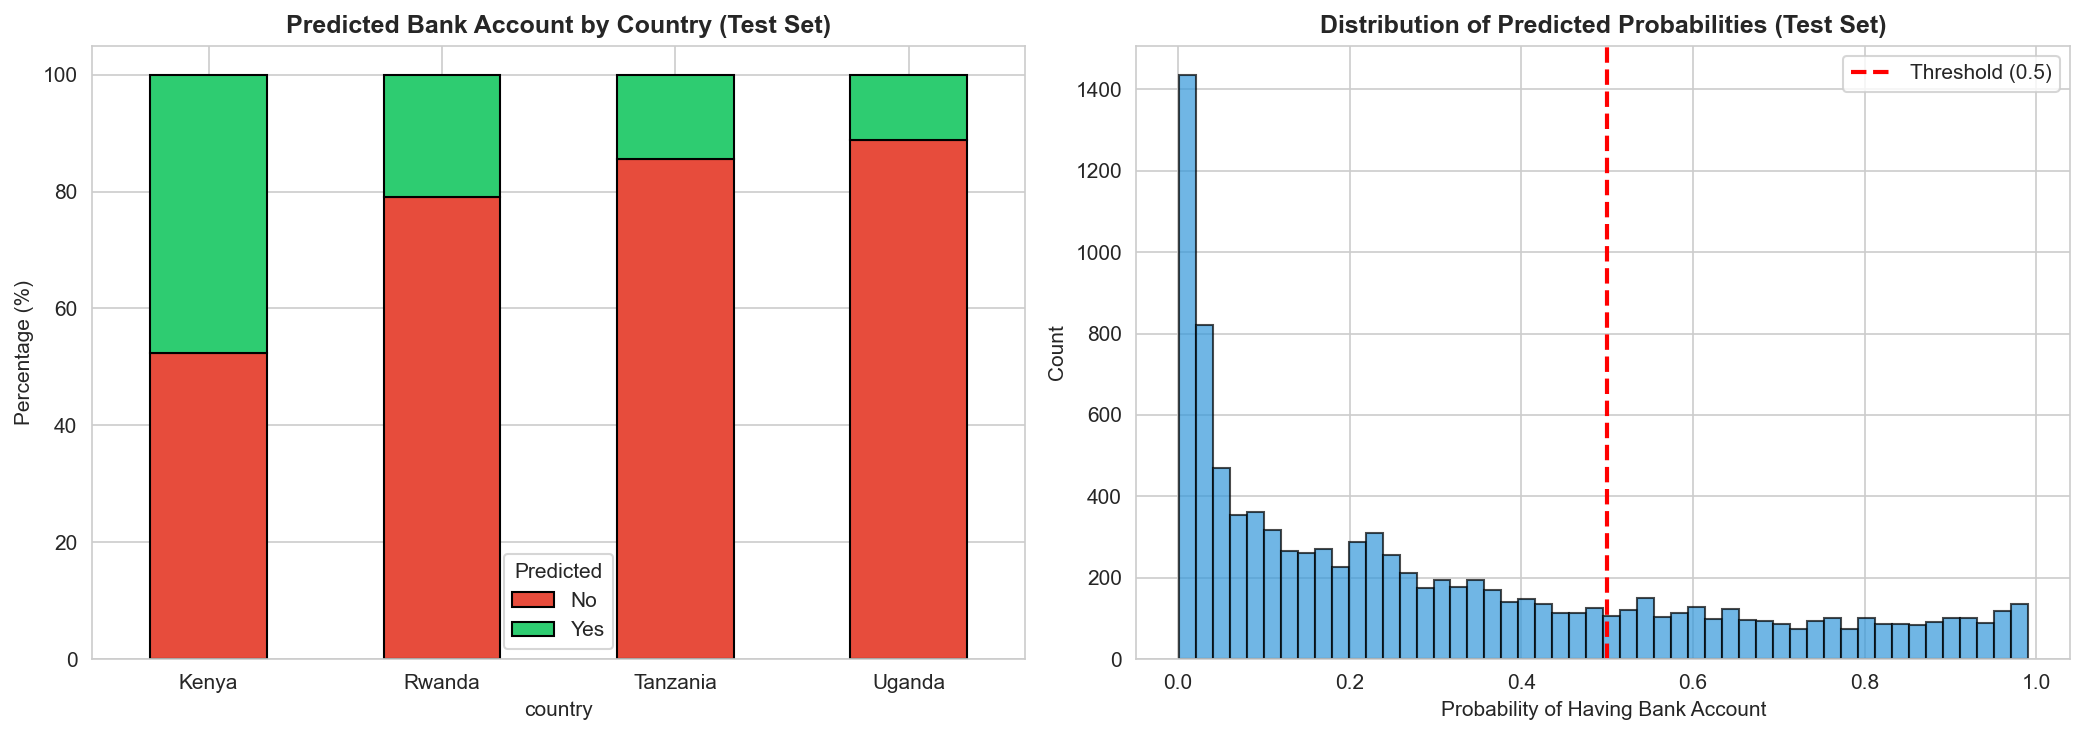

In [36]:
# Visualize predictions on Test data by country
test_df['predicted_bank_account'] = test_predictions
test_df['predicted_probability'] = test_probabilities

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prediction distribution by country
ct = pd.crosstab(test_df['country'], test_df['predicted_bank_account'], normalize='index') * 100
ct.columns = ['No', 'Yes']
ct.plot(kind='bar', stacked=True, ax=axes[0], color=['#e74c3c', '#2ecc71'], edgecolor='black')
axes[0].set_title('Predicted Bank Account by Country (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='Predicted')

# Probability distribution
axes[1].hist(test_probabilities, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_title('Distribution of Predicted Probabilities (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Probability of Having Bank Account')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
fig.savefig("figures/fig14_Prediction_Test_Dataset.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## 12. Summary and Conclusions

**Classification Results:**
- Gradient Boosting achieved the best baseline performance (F1=0.49, AUC=0.87)
- Class imbalance handling (oversampling + class weights) improved recall by up to 54.8 pp and F1 across all models
- The improved Random Forest achieved the best overall F1-Score (0.529)

**Test Set Predictions:**
- The best model (Improved Gradient Boosting) was applied to the unseen Test.csv (10,086 individuals)
- Predictions were saved in Zindi submission format

**Clustering Results:**
- K-Means and Hierarchical clustering identified 4 meaningful demographic groups
- Clusters differ by country, age, education, and employment type

**Key Findings:**
- Education, job type, and country are the strongest predictors of bank account ownership
- Kenya has the highest financial inclusion rate among EAC countries
- Urban residents with cellphone access are significantly more likely to have bank accounts
- Addressing class imbalance is critical for building fair and useful predictive models in financial inclusion